## **Цель**:

Оценка эффективности новой системы рекомендаций на платформе онлайн-супермаркета.

## **Данные**

**Всего есть три датасета:**

orders_ab.csv — информация о заказах:

**・** order_id - id заказа

**・** creation_time - время создания заказа

**・** product_ids - id продукта

products_ab.csv — информация о продуктах:

**・** product_id	- id продукта

**・** name - имя продукта

**・** price - цена продукта

users_data_ab.csv — информация о пользователях:

**・** user_id - id пользователя

**・** order_id	- id заказа

**・** action	- действие

**・** time - точное время заказа

**・** date	- дата заказа

**・** group - контрольная группа

## **План действий:**


1. **Небольшой предварительный анализ:**

**・** Загрузка данных и их изучение

**・** Чистка и объединение данных (если нужно)

**・** Проверка соответствия данных формат/равномерность

2. **Общая оценка данных A/B тест:**

**・** Ставим гипотезы и проводим статистические тесты

3. **Итоги:**

**・** Формулируем общие итоги

**・** Подводим итоги статистических наблюдений

**・** Вывод.

In [2]:
# Импортируем нужные библиотеки
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway, kruskal, ttest_ind, mannwhitneyu, fisher_exact, levene
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# Загрузка данных
orders = pd.read_csv("/content/drive/MyDrive/Datasets/orders_ab.csv")
products = pd.read_csv("/content/drive/MyDrive/Datasets/products_ab.csv")
users_data = pd.read_csv("/content/drive/MyDrive/Datasets/users_data_ab.csv")

In [ ]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB


In [ ]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [ ]:
users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [ ]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4337 non-null   int64 
 1   order_id  4337 non-null   int64 
 2   action    4337 non-null   object
 3   time      4337 non-null   object
 4   date      4337 non-null   object
 5   group     4337 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 203.4+ KB


In [ ]:
users_data.group.unique()

array([0, 1])

In [ ]:
# Общее число уникальных пользователей
users_data.user_id.nunique()

1017

### Объединяем таблицы для дальнейшего удобства работы:

In [5]:
# Объединим заказы с информацией о пользователях
merged_data = users_data.merge(orders, on="order_id", how="left")

merged_data.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56.000000,"{74, 6}"
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [6]:
# Разворачиваем 'product_ids' в отдельные строки, чтобы присоединить цены товаров
merged_data['product_ids'] = merged_data['product_ids'].str.strip('{}').str.split(',')
merged_data = merged_data.explode('product_ids')
merged_data['product_ids'] = merged_data['product_ids'].astype(int)

merged_data.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,22
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,53
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,84
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,56


In [7]:
# Присоединение данных о продуктах
merged_data = merged_data.merge(products, left_on="product_ids", right_on="product_id", how="left")

merged_data.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,22,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,53,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,84,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,56,56,сосиски,150.0


In [8]:
# Вычисляем общую стоимость заказа
merged_data['total_price'] = merged_data.groupby('order_id')['price'].transform('sum')

merged_data.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,product_id,name,price,total_price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75,75,сок ананасовый,120.0,408.7
1,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,22,22,сок мультифрукт,120.0,408.7
2,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,53,53,мука,78.3,408.7
3,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,84,84,мандарины,90.4,408.7
4,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,56,56,сосиски,150.0,250.5


Разделяем полученную таблицу на группы и создаем отдельную мини-таблицу для групп по уникальным пользователям.

Такая мини-таблица нужна для оценки групп для дальнейшего проведения А/B тестов. Данные в обоих таблицах желательно должны быть равными по количеству, в ином случае можно сократить один из них.

In [31]:
# Разделяем на группы

# Получаем уникальные user_id по группам
group_1 = merged_data[merged_data['group'] == 1]
group_0 = merged_data[merged_data['group'] == 0]

In [32]:
group_0.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,product_id,name,price,total_price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75,75,сок ананасовый,120.0,408.7
1,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,22,22,сок мультифрукт,120.0,408.7
2,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,53,53,мука,78.3,408.7
3,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,84,84,мандарины,90.4,408.7
7,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,76,76,чай черный в пакетиках,55.5,310.2


In [10]:
group_1.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,product_id,name,price,total_price
4,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,56,56,сосиски,150.0,250.5
5,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,76,76,чай черный в пакетиках,55.5,250.5
6,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,39,39,бублики,45.0,250.5
13,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,2022-08-26 00:03:37.000000,20,20,батон,50.0,228.0
14,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,2022-08-26 00:03:37.000000,45,45,чай зеленый листовой,78.0,228.0


In [ ]:
# Количество записей в таблице group_1
count_group_1 = group_1.shape[0]

# Количество записей в таблице group_0
count_group_0 = group_0.shape[0]

print(f"Количество записей в таблице group_1: {count_group_1}")
print(f"Количество записей в таблице group_0: {count_group_0}")

Количество записей в таблице group_1: 8892
Количество записей в таблице group_0: 5677


In [ ]:
# Оставляем только первую запись для каждого уникального user_id
unique_users = merged_data.drop_duplicates(subset='user_id', keep='first')

# Разделяем уникальных пользователей на две группы
group_0_unique_users = unique_users[unique_users['group'] == 0]
group_1_unique_users = unique_users[unique_users['group'] == 1]

In [ ]:
unique_users_count_group_1 = group_1_unique_users.shape[0]
unique_users_count_group_0 = group_0_unique_users.shape[0]
print(f"Количество записей в таблице group_1: {unique_users_count_group_1}")
print(f"Количество записей в таблице group_0: {unique_users_count_group_0}")

Количество записей в таблице group_1: 502
Количество записей в таблице group_0: 515


Количество пользователей примерно равны в обеих группах.

Проверим, уникальны ли пользователи в каждой группе, нет ли одних и тех же пользователей в разных выборках:

In [ ]:
group_0_unique_users.query('user_id in @group_1_unique_users.user_id').shape[0]

0

In [ ]:
group_0_unique_users.duplicated().sum()

0

In [ ]:
group_1_unique_users.duplicated().sum()

0

In [ ]:
# Процент 1 контрольной группы
group_0_unique_users.shape[0]/unique_users.shape[0]*100

50.63913470993116

In [ ]:
# Процент 2 контрольной группы
group_1_unique_users.shape[0]/unique_users.shape[0]*100

49.36086529006883

Для убеждения в равном разделении пользователей между группами добавим статистический анализ.

Используем критерий Хи-квадрат с ожидаемыми и наблюдаемыми частотами:

**H0**: ожидаемые и наблюдаемые частоты данных статистически значимо не различаются в группах (*p-value* > 0.05)

**H1**: ожидаемые и наблюдаемые частоты данных статистически значимо различаются в группах

Для оценки равенства групп мы можем использовать Хи-квадрат тест или точный тест Фишера. Считается, что точный тест Фишера подходит лучше для сравнений, когда один размер группы намного больше другого или когда числа относительно малы. Хи-квадрат тест может быть менее чувствительным к дисбалансу при больших значениях.

Если *p-значение* ≥ 0.05, различия между группами считаются незначительными, и они могут рассматриваться как статистически равные по численности.

In [ ]:
contingency_table = [[unique_users_count_group_1], [unique_users_count_group_0]]

chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"p-значение: {p}")

if p < 0.05:
    print("Статистически значимая разница в размерах групп.")
else:
    print("Размеры групп статистически равны.")

p-значение: 1.0
Размеры групп статистически равны.


In [ ]:
table = [[unique_users_count_group_1, unique_users_count_group_0],
         [users_data.shape[0] - unique_users_count_group_1, users_data.shape[0] - unique_users_count_group_0]]

_, p_value = fisher_exact(table)

print(f"p-значение: {p_value}")

if p_value < 0.05:
    print("Существуют статистически значимые различия в количестве пользователей между группами.")
else:
    print("Нет статистически значимых различий в количестве пользователей между группами.")

p-значение: 0.6888050908941431
Нет статистически значимых различий в количестве пользователей между группами.


### Проверим время проведения теста в обоих группах:

Если дата проведения не совпадает, то отфильтруем лишних пользователей по времени.

In [ ]:
group_0.time.min(), group_0.time.max()

('2022-08-26 00:00:19.000000', '2022-09-08 23:41:24.000000')

In [ ]:
group_1.time.min(), group_1.time.max()

('2022-08-26 00:02:21.000000', '2022-09-08 23:18:05.000000')

Окончание эксперимента плюс-минус совпадает у всех групп.

## 2: Общая оценка данных

Считаем средний доход с каждого пользователя по группам:

In [19]:
user_avg_price0 = group_0.groupby('user_id')['total_price'].mean().sum()
user_avg_price1 = group_1.groupby('user_id')['total_price'].mean().sum()

print("Совокупный доход с пользователей первой группы:" , user_avg_price0, "\nСовокупный доход с пользователей второй группы:", user_avg_price1)

Совокупный доход с пользователей первой группы: 226742.57407067454 
Совокупный доход с пользователей второй группы: 226610.80723479757


Мы можем видеть, что внедрение новой системы рекомендаций особо не повлияло на доходы. Посмотрим, так ли это на самом деле.


### 0. Сравнение сумм покупок:

Используем t-тест для проверки различий в среднем количестве покупок на пользователя в группах 0 и 1.

**H0**: нет статистически значимой разницы между средней суммой покупок в группах 0 и 1.

**H1**: статистически значимая разница есть.

*t-test:* Это будет показатель, который говорит о различиях между группами. Чем выше значение t, тем больше различия между группами.

*p-value:* Это значение позволяет понять, является ли наблюдаемое различие статистически значимым. Если p-значение меньше уровня значимости (в нашем случае 0.05), то различия считаются значимыми.

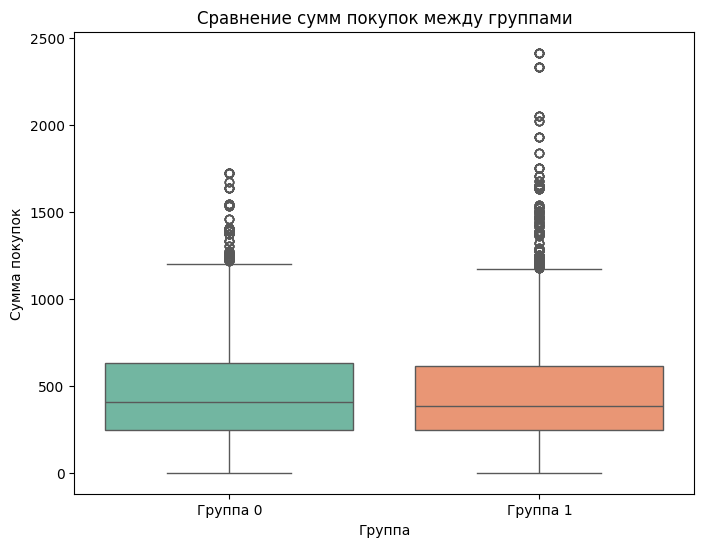

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='group', y='total_price', data=merged_data, palette="Set2")
plt.title('Сравнение сумм покупок между группами')
plt.xlabel('Группа')
plt.ylabel('Сумма покупок')
plt.xticks([0, 1], ['Группа 0', 'Группа 1'])
plt.show()

In [33]:
group_0_produits_sum = group_0['total_price']
group_1_produits_sum = group_1['total_price']

stat, p_value = stats.ttest_ind(group_0_produits_sum, group_1_produits_sum)

print(f"t-test: {stat}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Есть статистически значимая разница между группами.")
else:
    print("Статистически значимой разницы между группами нет.")

t-test: 0.39986432136151795
p-value: 0.6892623152169639
Статистически значимой разницы между группами нет.


### 1. Общее сравнение количества продуктов в заказе на пользователя:

Некоторые пользователи заказывали несколько раз.

Используем t-тест для проверки различий в среднем количестве покупок на пользователя в группах 0 и 1.

**H0**: нет статистически значимой разницы между средним количеством покупок в группах 0 и 1.

**H1**: статистически значимая разница есть.

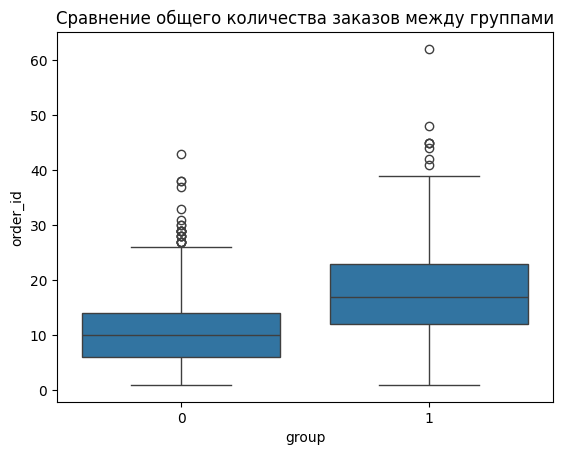

In [ ]:
user_orders = merged_data.groupby(['user_id', 'group'])['order_id'].count().reset_index()

sns.boxplot(x='group', y='order_id', data=user_orders)
plt.title('Сравнение общего количества заказов между группами')
plt.show()

In [ ]:
group_0 = user_orders[user_orders['group'] == 0]['order_id']
group_1 = user_orders[user_orders['group'] == 1]['order_id']

stat, p_value = stats.ttest_ind(group_0, group_1)

print(f"t-статистика: {stat}")
print(f"p-значение: {p_value}")

t-статистика: -13.624031571690642
p-значение: 6.108540480706531e-39


Различия между количеством покупок между группами (по пользователям) очень существенные и не случайны.


### 2. Сравнение количества продуктов (разнообразных) по пользователям:

Используем t-тест для проверки различий в среднем количестве разнообразных продуктов на пользователя в группах 0 и 1.

**H0**: нет статистически значимой разницы между средним количеством покупок в группах 0 и 1.

**H1**: статистически значимая разница есть.

In [35]:
orders_per_user = merged_data.groupby(['user_id', 'group'])['order_id'].nunique().reset_index()

group_0_orders = orders_per_user[orders_per_user['group'] == 0]['order_id']
group_1_orders = orders_per_user[orders_per_user['group'] == 1]['order_id']

stat, p = stats.ttest_ind(group_0_orders, group_1_orders)

print(f"Статистика t-теста: {stat}")
print(f"p-значение: {p}")

Статистика t-теста: -14.51086812343365
p-значение: 1.6974865514796019e-43


**Результат**: это свидетельствует о статистически значимом различии между группами


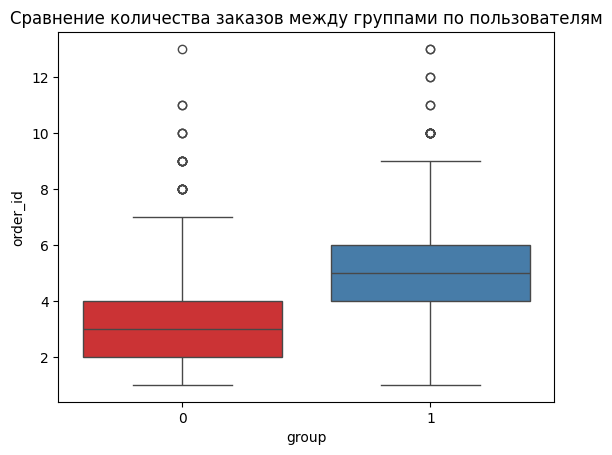

In [36]:
sns.boxplot(x='group', y='order_id', data=orders_per_user, palette='Set1')
plt.title('Сравнение количества заказов между группами по пользователям')
plt.show()

### 3. Распродажа в магазине?

Количество купленных продуктов выросло, но при этом сумма всех покупок осталась на прежнем уровне. Может во время проведении теста магазин запустил акцию? Проверим изменение цен на продукты в обеих группах:

In [29]:
group_0_produits = group_0[['name', 'price']].drop_duplicates(subset='name')
group_1_produits = group_1[['name', 'price']].drop_duplicates(subset='name')

common_products = pd.merge(group_0_produits, group_1_produits, on='name', suffixes=('_group_0', '_group_1'))

common_products['price_difference'] = common_products['price_group_1'] - common_products['price_group_0']

print(common_products)

                      name  price_group_0  price_group_1  price_difference
0           сок ананасовый          120.0          120.0               0.0
1          сок мультифрукт          120.0          120.0               0.0
2                     мука           78.3           78.3               0.0
3                мандарины           90.4           90.4               0.0
4   чай черный в пакетиках           55.5           55.5               0.0
..                     ...            ...            ...               ...
82                 леденцы           45.5           45.5               0.0
83                    икра          800.0          800.0               0.0
84         масло кунжутное          250.0          250.0               0.0
85           масло льняное          200.0          200.0               0.0
86              сухофрукты           55.0           55.0               0.0

[87 rows x 4 columns]


**Результат:** цены в обеих группах одинаковые. Акции не было.

### 4. Сравнение распределения продуктов

Есть ли группа продуктов-"фаворитов", которых купили больше всего в тестовой группе? Поменялся ил популярность товаров при введении новой рекомендационной системы? Проверим распределение продуктов в обеих группах:

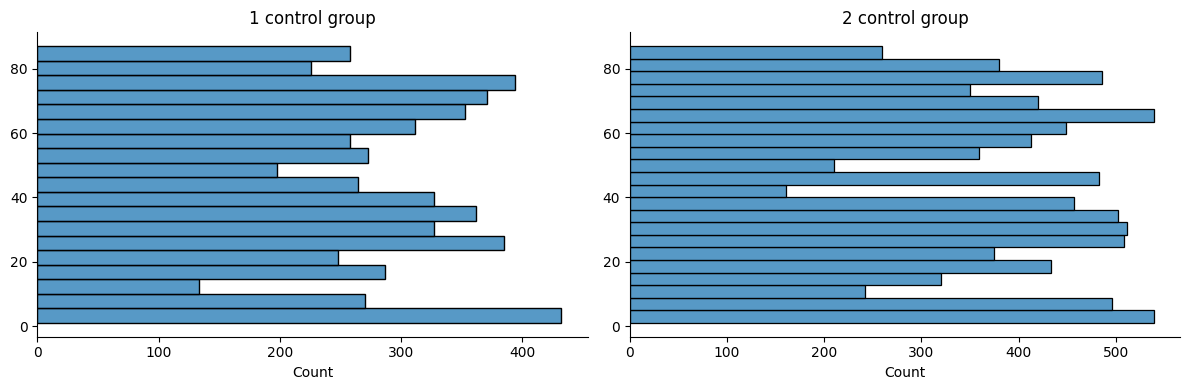

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(y=group_0.product_id.sort_values(ascending=False), ax = axes[0])
axes[0].set(title='1 control group', ylabel='')

sns.histplot(y=group_1.product_id.sort_values(ascending=False), ax = axes[1])
axes[1].set(title='2 control group', ylabel='')

sns.despine()
plt.tight_layout()

Сравним наши распределения с помощью статистического теста.

Есть категориальные переменные (айди продукта, группа пользователя) → нужен хи-квадрат

**H0**: нет статистически значимой разницы между распределениями пользователей по странам в тестовой и контрольных группах (p-value > 0.05)

**H1**: есть статистически значимая разница между распределениями пользователей по странам в тестовой и контрольных группах

In [ ]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(merged_data.product_id, merged_data.group))
stat, p

(83.88657122236731, 0.5443984355373789)

**Результат:** по результатам теста Хи-квадрат не обнаружено значимого различия в распределении пользователей групп (0 и 1) по количеству купленных определенных видов товаров.

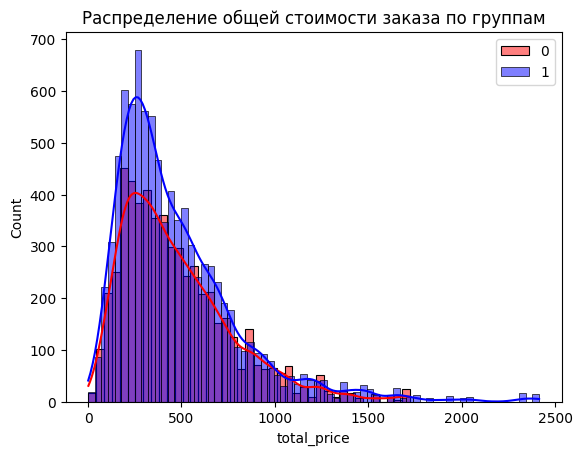

In [ ]:
sns.histplot(group_0['total_price'], color='red', label='0', kde=True)
sns.histplot(group_1['total_price'], color='blue', label='1', kde=True)
plt.legend()
plt.title("Распределение общей стоимости заказа по группам")
plt.show()

# Итоги:

Из предоставленных датасетов были использованы все.



Количество пользователей в первой группе: 515

Во второй группе: 502.

Время начала и окончания теста в обеих группах примерно одинаковая: 2022-08-26 - 2022-09-08.

Это позволило провести тест без уменьшения количества пользователей в какой-либо группе и не исключать пользователей из групп не соответсвующих по времени.

### Согласно проведенным исследованиям:

1. Доход с обеих групп примерно одинаковый:

Совокупный доход с пользователей первой группы: 226742.5 руб.;

Совокупный доход с пользователей второй группы: 226610.8 руб.

2. Сумма покупок на каждого пользователя тоже примерно одинаковая.

3. Общее количество купленных продуктов возросло.

4. Тип продуктов в корзине в среднем тоже возросло.

5. Проверили, не было ли никаких акции во время проведения теста, так как люди склонны покупать "больше товаров за те же деньги". Акции не было.

6. Поменялось ли тип покупаемых продуктов во время внедрения новой RecSys? Распределение примерно одинаковое, значительно ничего не поменялось.

**Вывод**: итоги теста довольно сомнительные: суммы заказов в обеих группах остались прежними, но количество заказов выросло. Ухудшения в доходах не замечено. Можно внедрять новую рекомендационную систему, но необходимо следить за ключевыми показателями.